<a href="https://colab.research.google.com/github/Rajeeb321123/Ai-chat-buddy/blob/master/unsloth_llama3b_instruct_Nepali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import torch
major_version, minor_version = torch.cuda.get_device_capability()
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
if major_version >= 8:
    !pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes
else:
    !pip install --no-deps xformers trl peft accelerate bitsandbytes
pass

In [ ]:
!pip install --upgrade trl

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! Llama 3 is up to 8k
dtype = None
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

fourbit_models = [
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
    "unsloth/llama-2-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",
    "unsloth/gemma-7b-it-bnb-4bit",
    "unsloth/gemma-2b-bnb-4bit",
    "unsloth/gemma-2b-it-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",
]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll



---



Next, we integrate LoRA adapters into our model, which allows us to efficiently update just a fraction of the model's parameters, enhancing training speed and reducing computational load.

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

Then, we define a system prompt that formats tasks into instructions, inputs, and responses, and apply it to a dataset to prepare our inputs and outputs for the model, with an EOS token to signal completion.


In [ ]:
# this is basically the system prompt
alpaca_prompt = """Below is instructions in Nepali Language that describes a task, paired with an input that provides further context. Write a response in Nepali language that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions =  examples["nepali_instruction"]
    inputs       = examples["nepali_input"]
    outputs      = examples["nepali_output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

In [ ]:
from datasets import load_dataset
ds = load_dataset('Telugu-LLM-Labs/nepali_alpaca_yahma_cleaned_filtered',split = "train")

Generating train split:   0%|          | 0/28910 [00:00<?, ? examples/s]

In [ ]:
dataset = ds.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/28910 [00:00<?, ? examples/s]

In [ ]:
dataset[2]

{'instruction': 'Describe the structure of an atom.',
 'input': '',
 'output': "An atom is the basic building block of all matter and is made up of three types of particles: protons, neutrons, and electrons. The structure of an atom can be described as a nucleus at the center surrounded by a cloud of electrons.\n\nThe nucleus of an atom is made up of protons and neutrons. Protons are positively charged particles and neutrons are neutral particles with no charge. Both of these particles are located in the nucleus of the atom, which is at the center of the atom and contains most of the atom's mass.\n\nSurrounding the nucleus of the atom is a cloud of electrons. Electrons are negatively charged particles that are in constant motion around the nucleus. The electron cloud is divided into shells or orbitals, and each shell can hold a certain number of electrons. The number of electrons in the outermost shell, called the valence shell, determines the chemical properties of the atom. \n\nIn a 

In [ ]:
dataset

Dataset({
    features: ['instruction', 'input', 'output', 'nepali_instruction', 'nepali_input', 'nepali_output', 'text'],
    num_rows: 28910
})

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'nepali_instruction', 'nepali_input', 'nepali_output', 'text'],
        num_rows: 23128
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'nepali_instruction', 'nepali_input', 'nepali_output', 'text'],
        num_rows: 5782
    })
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'nepali_instruction', 'nepali_input', 'nepali_output', 'text'],
        num_rows: 23128
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'nepali_instruction', 'nepali_input', 'nepali_output', 'text'],
        num_rows: 5782
    })
})

In [ ]:
train_dataset = dataset["train"] # Access the training split using the key 'train'
eval_dataset = dataset["test"]   # Access the testing split using the key 'test'
print(train_dataset)             # Print the training dataset

Dataset({
    features: ['instruction', 'input', 'output', 'nepali_instruction', 'nepali_input', 'nepali_output', 'text'],
    num_rows: 23128
})


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

# On orginal tokenizer

<a name="Train"></a>
### Train the model
- We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.
- At this stage, we're configuring our model's training setup, where we define things like batch size and learning rate, to teach our model effectively with the data we have prepared.

In [ ]:
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    # eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = True, # Moved packing argument here
    args = TrainingArguments(
      per_device_train_batch_size = 2,
      gradient_accumulation_steps = 4,
      max_steps = 5,
      # eval_steps = 10,
      # save_strategy = "steps",
      # save_steps = 1,
      # save_total_limit = 3,
      # logging_strategy = "steps",
      warmup_steps = 5,
      # eval_strategy = "steps",
      # do_eval= True,
      # label_names = ["labels"],
      learning_rate = 2e-4,
      fp16 = not is_bfloat16_supported(),
      bf16 = is_bfloat16_supported(),
      logging_steps = 1,
      optim = "adamw_8bit",
      weight_decay = 0.01,
      lr_scheduler_type = "cosine",
      seed = 3407,
      output_dir = "outputs",
      # load_best_at_end = True,
      # metric_for_best_model = "eval_loss",
    ),
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:181: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_f

Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [ ]:
# Add padding and truncation to the tokenizer
 # Set padding token if not already set
trainer.args.padding = True  # Enable padding
trainer.args.truncation = True # Enable truncation

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.605 GB of memory reserved.


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

179

In [ ]:
# We're now kicking off the actual training of our model, which will spit out some statistics showing us how well it learns
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 6,572 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 5
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.758600
2,1.695600
3,1.631900
4,1.682500
5,1.517100


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

233.6979 seconds used for training.
3.89 minutes used for training.
Peak reserved memory = 10.436 GB.
Peak reserved memory for training = 4.831 GB.
Peak reserved memory % of max memory = 70.762 %.
Peak reserved memory for training % of max memory = 32.757 %.



## Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    alpaca_prompt.format(
        "", # input
        "स्वस्थ रहनका लागि तीन वटा टिप्स दिनुहोस् ।",
        "",
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|>Below is instructions in Nepali Language that describes a task, paired with an input that provides further context. Write a response in Nepali language that appropriately completes the request.\n\n### Instruction:\n\n\n### Input:\nस्वस्थ रहनका लागि तीन वटा टिप्स दिनुहोस् ।\n\n### Response:\n1. रातमा पाँच घण्टा निद्रा लिनुहोस् ।\n2. प्रतिदिन 30 मिनिटका लागि कसरी चल्ने हो?\n3. प्रतिदिन 30 मिनिटका लागि कसरी चल्ने हो?<|end_of_text|>']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

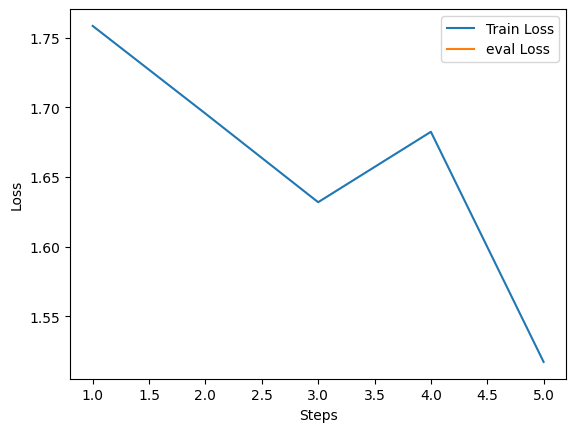

In [ ]:
import matplotlib.pyplot as plt

# Initialize list to hold training and evaluation losses and steps
train_losses = []
eval_losses = []
train_step = []
eval_step = []

#Populate the list from log history
#import pandas as pd
# pd.DataFrame(trainer.state.log_history)
for entry in trainer.state.log_history:
  if 'loss' in entry:
    train_losses.append(entry['loss'])
    train_step.append(entry['step'])
  if 'eval_loss' in entry:
    eval_losses.append(entry['eval_loss'])
    eval_step.append(entry['step'])

# plot the losses
plt.plot(train_step, train_losses, label = 'Train Loss')
plt.plot(eval_step, eval_losses, label = 'eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

In [ ]:
# Save to q4_k_m GGUF
if True: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

# On Custom tokenizer

- I train the tokenizer on Nepali corpus and increase the vocab length from 128k to 140k

In [ ]:
!pip install -q accelerate peft bitsandbytes transformers trl huggingface_hub

## Step 1: Install Packages

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

## Step 3: import Required libraries

In [ ]:
import os
import torch
from datasets import load_dataset

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
)

from peft import LoraConfig, PeftModel
from trl import SFTTrainer,SFTConfig

## Step 4: load everything and start fine-tunning process

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Rajeeb321/unsloth-llama-3-8b-bnb-4bit-Nepali-tokenizer")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

In [ ]:
tokenizer.vocab_size

140000

In [ ]:
# this is basically the system prompt
alpaca_prompt = """Below is instructions in Nepali Language that describes a task, paired with an input that provides further context. Write a response in Nepali language that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions =  examples["nepali_instruction"]
    inputs       = examples["nepali_input"]
    outputs      = examples["nepali_output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
tokenizer.eos_token

'<|end_of_text|>'

In [ ]:
from datasets import load_dataset
ds = load_dataset('Telugu-LLM-Labs/nepali_alpaca_yahma_cleaned_filtered',split = "train")

Generating train split:   0%|          | 0/28910 [00:00<?, ? examples/s]

In [ ]:
dataset = ds.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/28910 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'nepali_instruction', 'nepali_input', 'nepali_output', 'text'],
        num_rows: 23128
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'nepali_instruction', 'nepali_input', 'nepali_output', 'text'],
        num_rows: 5782
    })
})

In [ ]:
train_dataset = dataset["train"] # Access the training split using the key 'train'
eval_dataset = dataset["test"]   # Access the testing split using the key 'test'
print(train_dataset)

Dataset({
    features: ['instruction', 'input', 'output', 'nepali_instruction', 'nepali_input', 'nepali_output', 'text'],
    num_rows: 23128
})


In [ ]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, "float16")
model_name = "unsloth/llama-3-8b-bnb-4bit"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)
model.config.use_cache = False
model.config.pretraining_tp = 1



# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
)


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:167: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(140000, 4096)

In [ ]:
from transformers import TrainingArguments


trainer = SFTTrainer(
    model = model,
    peft_config=peft_config,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    # eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    packing = True, # Moved packing argument here
    args = TrainingArguments(
      per_device_train_batch_size = 2,
      gradient_accumulation_steps = 4,
      max_steps = 5,
      # eval_steps = 10,
      # save_strategy = "steps",
      # save_steps = 1,
      # save_total_limit = 3,
      # logging_strategy = "steps",
      warmup_steps = 5,
      # eval_strategy = "steps",
      # do_eval= True,
      # label_names = ["labels"],
      learning_rate = 2e-4,
      fp16 = True,
      bf16 = False,
      logging_steps = 1,
      optim = "adamw_8bit",
      weight_decay = 0.01,
      lr_scheduler_type = "cosine",
      seed = 3407,
      output_dir = "outputs",
      # load_best_at_end = True,
      # metric_for_best_model = "eval_loss",
    ),
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_num_proc, packing. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:181: UserWarning: You passed a `packing` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 o

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:397: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
9.252 GB of memory reserved.


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
trainer_stats = trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 

In [ ]:
FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
    alpaca_prompt.format(
        "", # input
        "स्वस्थ रहनका लागि तीन वटा टिप्स दिनुहोस् ।",
        "",
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
tokenizer.batch_decode(outputs)

In [ ]:
import matplotlib.pyplot as plt

# Initialize list to hold training and evaluation losses and steps
train_losses = []
eval_losses = []
train_step = []
eval_step = []

#Populate the list from log history
#import pandas as pd
# pd.DataFrame(trainer.state.log_history)
for entry in trainer.state.log_history:
  if 'loss' in entry:
    train_losses.append(entry['loss'])
    train_step.append(entry['step'])
  if 'eval_loss' in entry:
    eval_losses.append(entry['eval_loss'])
    eval_step.append(entry['step'])

# plot the losses
plt.plot(train_step, train_losses, label = 'Train Loss')
plt.plot(eval_step, eval_losses, label = 'eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

In [ ]:
# Save to q4_k_m GGUF
if True: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")